# Validation of NISAR Requirement L2-SCI-667:  </br>Ice sheet and glacier velocity measurement - slow deformation
---

This notebook documents and executes the steps need to validate the NISAR slow ice deformation requirement (L2-SCI-667), which is specified as:

**The NISAR Project shall measure ice sheet (> 90% coverage, including both poles) and glaciers and ice-caps (> 80% coverage) horizontal velocity each cold season to an accuracy
 better than the sum of 3% of the horizontal velocity magnitude and 1 m/yr (1-sigma), at 100-m resolution in areas of slow deformation (< 50 m/yr).**

As described below this process amounts to comparing L3 velocity products generated as described in the NISAR ATBD with points of known velocity and elevations. Specifically, the Cal/Val points will consist of:
* Zero velocity points on exposed bedrock; and
* On-ice GPS measurements of ice flow speed ($v_x$,$v_y$) and elevation ($z$).

Errors are evaluated as the means ($\mu_x,\mu_y$), standard deviations ($\sigma_x,\sigma_y$), and root-mean-squares (rms) of the diferences between the SAR-measured velocity ($v_x,v_y$) and the nominally GPS-measured cal/val points ($u_x,u_y$). Explicitly, these calculations are:

$\bar{\mu}_x = \frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (v_x-u_x)$, &nbsp;&nbsp;&nbsp;       $\bar{\mu}_y = \frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (v_x-u_x)$ </br>
$\hat{\sigma}_x^2 = \frac{1}{N_{pts}-1}\sum \limits_{i=1}^{N_{pts}} ((v_x-u_x)-\bar{\mu_x})^2$, &nbsp;&nbsp;&nbsp;    $\hat{\sigma}_y^2 = \frac{1}{N_{pts}-1}\sum \limits_{i=1}^{N_{pts}} ((v_y-u_y)-\bar{\mu_y})^2$ </br>
$rms_x = \sqrt{\frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} ((v_x-u_x))^2}$, &nbsp;&nbsp;&nbsp; 
$rms_y = \sqrt{\frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} ((v_y-u_y))^2}$

The requirement poses the error in terms of a fixed value (1 m/yr) and percentage error (3%). To pass the requirement for a set of points, the mean error of the results should be less than the mean error thresholds for the point. Conceptually, if not rigorously, these two error sources can be thought of as the precision component (1 m/yr) and potential bias (3%). Consistent biases at a point through time may be caused by processing artifacts such as a slope error in the DEM used to apply the surface parallel flow correction. Specifically, the error should be less than:

${thresh}_x = \sqrt{\frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (1)^2 + (0.03u_x)^2 }$ m/yr, &nbsp;&nbsp;&nbsp;    ${thresh}_y = \sqrt{\frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (1)^2 + (0.03u_y)^2 }$ m/yr

Since biases are possible, the requirement is met where the $rms$ for a component is less the than corresponding $thresh$.

The rest of this notebook is designed to access remotely stored L3 velocity maps and evaluate them using a set of GPS cal/val points. This notebook evaluates the differences between the GPS cal/val points and velocity maps produced by the Greenland Mapping Project sponsored by the NASA MEaSUREs program. The rms values of these differences are used to determine whether the above requirement is met. The S1 data used to derive this projection have a lower resolution than NISAR, hence the products are gridded at 200 rather than 100 m.

**A present this notebook is only a prototype and works using prodcuts created using data products derived using SAR data from sensors other than NISAR, albeit with the same algorithms and workflow. To emulate the points that will be collected by the project, this notebook uses a recently collected set of GPS points ([Hvidberg et al., 2020](https://tc.copernicus.org/articles/14/3487/2020/)). For purposes of demonstration, it is assumed that any changes in velocity with time are less than the uncertainty in the individual measurements.**

## Python Setup

In [1]:
%load_ext autoreload
%autoreload 2
import time
#
reset = False
try:
    import nisarcryodb
except Exception:
    %pip install -e ~/calvalDB/nisarcryodb
    reset = True
try:
    import nisargps
except Exception:
    %pip install -e ~/calvalDB/nisargps
    reset = True
if reset:
    print('\n\033[1;31m\n\nRestart kernel and run this cell again \n\n \033[0m\n''')
    time.sleep(1e9) # stop from advancing

In [2]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
import nisardev as nisar   #https://github.com/fastice/nisardev
import os
from urllib import request
import grimpfunc as grimp
import matplotlib.pyplot as plt
import panel
import numpy as np
from datetime import datetime
import pandas as pd
from dask.diagnostics import ProgressBar
ProgressBar().register()
panel.extension()

#Import libraries for CV database
import psycopg2 
import configparser
import getpass  
from psycopg2 import sql

#Import libraries for s3 access
import glob
import s3fs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
configFile = '../calvaldb_config.ini'

In [4]:
DB = nisarcryodb.nisarcryodb(configFile=configFile)

User name:  irj
Password:  ········


## Get GPS Data

Read the GPS data and compute velocities.

In [18]:
stationName = 'NIU1'
stationNIU1 = nisargps.nisarStation(stationName, DBConnection=DB, traceBack=False)

### 12 Day Time Series

Compute velocity at various intervals and over various periods.

In [31]:
method = 'regression'
date1 = '2024-05-01' 
date2 = '2024-07-31'

In [43]:
sampleInterval = 12 * 24 # Estimate every 12 days
dT = 24 * 12  # Compute speed over 12 day interval
date12, vx12, vy12, x1, y1 = stationNIU1.computeVelocityTimeSeries(date1, date2,
                                                                   dT, sampleInterval, method=method)
print(f'Sigma X, Y {np.nanstd(vx12):.3}, {np.nanstd(vy12):.3}')

Sigma X, Y 0.0882, 0.231


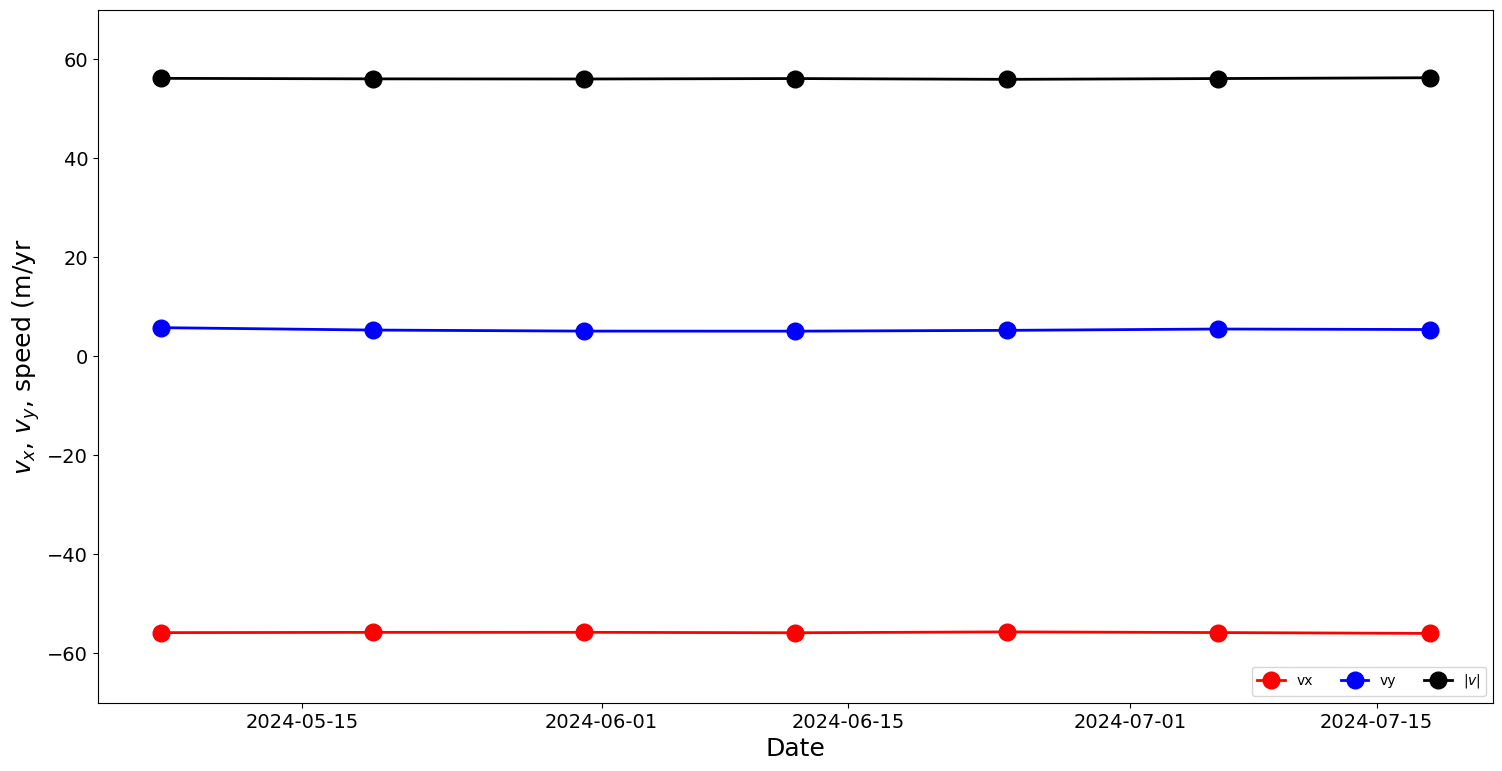

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
marker = 'o-'
linewidth = 2
markersize = 12
ax.plot(date12, vx12, f'r{marker}', label=f'vx', markersize=markersize, linewidth=linewidth)
ax.plot(date12, vy12, f'b{marker}', label=f'vy', markersize=markersize, linewidth=linewidth)
ax.plot(date12, np.sqrt(vx12**2 + vy12**2), f'k{marker}', label=f'$|v|$', markersize=markersize, linewidth=linewidth)
#
ax.set_ylabel('$v_x$, $v_y$, speed (m/yr', fontsize=18)  
ax.set_xlabel('Date', fontsize=18)
ax.set_ylim(-70, 70)
for lab  in ax.get_xticklabels() + ax.get_yticklabels():
    lab.set_fontsize(14)
ax.legend(loc='lower right', ncol=3)

### "Annual" Velocity

We don't actually have enough data for an annual velocity, so we will compute velocity over the entire period of the data for now. 

In [72]:
vxA, vyA, xA, yA = stationNIU1.computeVelocity(date1, date2)
vvA = np.sqrt(vxA**2 + vyA**2)
print(vx, vy, xA, yA)

-55.72103998105495 5.463164904622849 -93721.96772644875 -2508942.921613719


In [54]:
pad = 100e3
cvBounds = {'minx': xA - pad, 'miny': yA - pad, 'maxx': xA + pad, 'maxy': yA + pad}

## Get L3 Products

In [51]:
DB.listTableColumns( 'landice', 'l3_product', returnType=False, quiet=False);

product_id, start_date, end_date, resolution, accuracy, measurement_type, provider, product_type, product_path, product_version, software_version, config_file_path, date_created, archived, location_geom, notes


Get the paths to the products.

In [52]:
products = DB.getL3DateRangeProducts('2016-12-01', datetime(2024,11,30), filters={'product_path': '%vv%'})
products

product_path


{'2016-12-01.2017-11-30': {'vv': 's3://nisar-st-cryosphere-validation/test/velocity/measures-UW/data/GL_vel_mosaic_Annual_01Dec16_30Nov17_vv_v05.0.tif'},
 '2017-12-01.2018-11-30': {'vv': 's3://nisar-st-cryosphere-validation/test/velocity/measures-UW/data/GL_vel_mosaic_Annual_01Dec17_30Nov18_vv_v05.0.tif'},
 '2018-12-01.2019-11-30': {'vv': 's3://nisar-st-cryosphere-validation/test/velocity/measures-UW/data/GL_vel_mosaic_Annual_01Dec18_30Nov19_vv_v05.0.tif'}}

Set up NISAR velocity Series and subset using bounding box.

In [55]:
myCogs = [products[x]['vv'].replace('vv', '*').replace('.tif', '') for x in products]
print(myCogs)
myVelSeries = nisar.nisarVelSeries()
myVelSeries.readSeriesFromTiff(myCogs, url=False, readSpeed=False)
myVelSeries.subSetVel(cvBounds) # Apply subset
myVelSeries.loadRemote() # Load the data to memory


['s3://nisar-st-cryosphere-validation/test/velocity/measures-UW/data/GL_vel_mosaic_Annual_01Dec16_30Nov17_*_v05.0', 's3://nisar-st-cryosphere-validation/test/velocity/measures-UW/data/GL_vel_mosaic_Annual_01Dec17_30Nov18_*_v05.0', 's3://nisar-st-cryosphere-validation/test/velocity/measures-UW/data/GL_vel_mosaic_Annual_01Dec18_30Nov19_*_v05.0']
[########################################] | 100% Completed | 1.51 sms


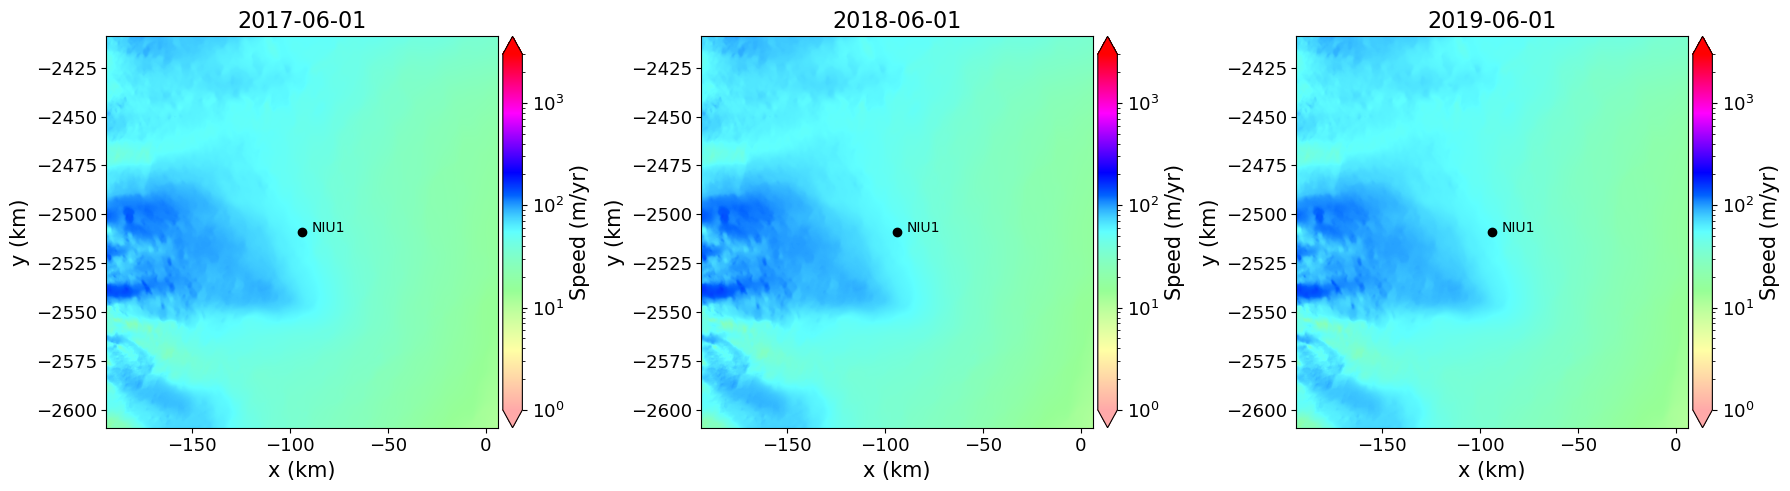

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, date in zip(axes, myVelSeries.time):
    myVelSeries.displayVelForDate(date=date, ax=ax, scale='log', units='km', vmin=1, vmax=3000)
    ax.plot(xA/1000, yA/1000, 'ko')
    ax.text(xA/1000 + 5, yA/1000, 'NIU1')
fig.tight_layout()

## Compare With GPS

Interpolate map velocities to GPS location.

In [124]:
tS = np.array([t.year for t in myVelSeries.time]).astype(int)
vxS, vyS, vvS = myVelSeries.interp(xA, yA)

Plot the velocity and velocity difference data.

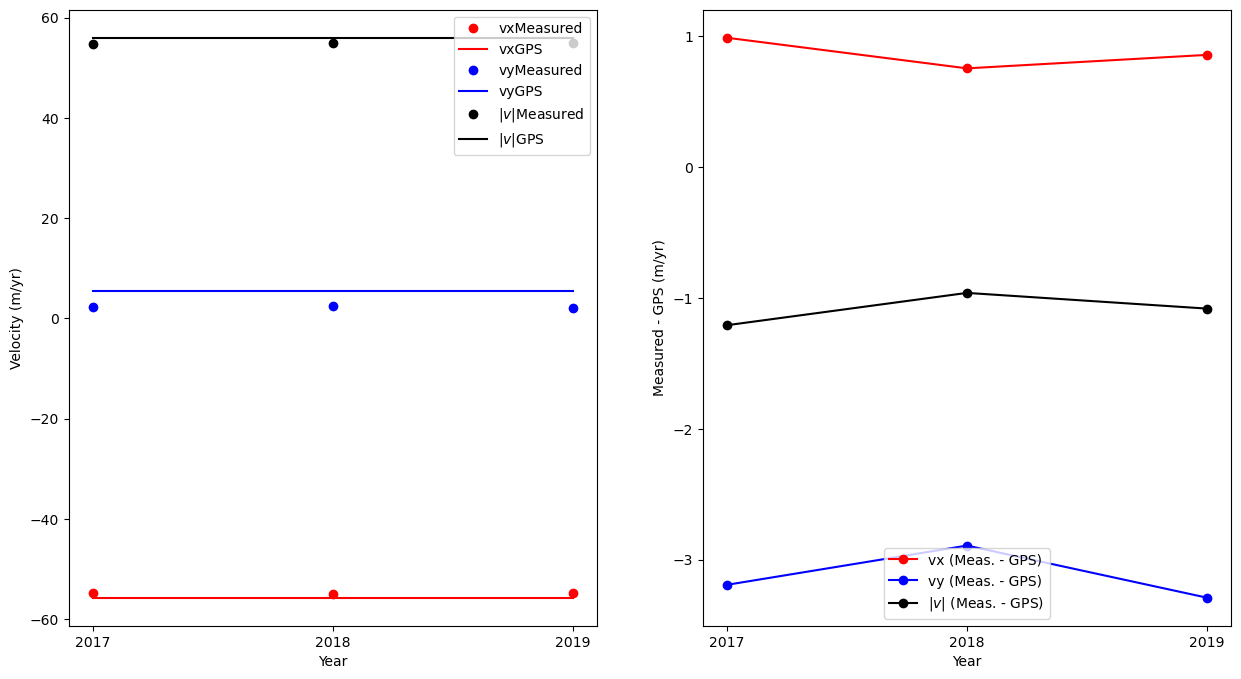

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
colors = ['r', 'b', 'k']
for v, vGPS, label, color in zip([vxS, vyS, vvS], [vxA, vyA, vvA], ['vx', 'vy', '$|v|$'], colors):
    axes[0].plot(tS, v, 'o', label=label + 'Measured', color=color)
    axes[0].plot(tS, [vGPS]*3, label=label + 'GPS', color=color)
    axes[1].plot(tS, v -vGPS, 'o-', label=label + ' (Meas. - GPS)', color=color)

for ax, xl, yl in zip(axes, ['Year', 'Year'], ['Velocity (m/yr)', 'Measured - GPS (m/yr)']):
    ax.legend()
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_xticks([2017, 2018, 2019])

Print individual errors.

In [137]:
print('Year    vx      vy      vv')
for vxpt, vypt, vvpt, t in zip(vxS, vyS, vvS, tS):
    print(f'{t}, {vxpt - vxA:.3f}, {vypt - vyA:.3f}, {vvpt - np.sqrt(vxA**2 + vyA**2):.3f}')

Year    vx      vy      vv
2017, 0.989, -3.192, -1.209
2018, 0.754, -2.892, -0.961
2019, 0.857, -3.291, -1.082
